In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import librosa
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import kaggle

# Descarga y procesado de datos

## Audios  de ruido para test

Descarga de la base de datos de kaggle

In [2]:
kaggle.api.authenticate()
kaggle.api.dataset_download_files("mmoreaux/environmental-sound-classification-50", path='../data_test/noise', unzip=True)

print("Audios de ruido descargados")

Dataset URL: https://www.kaggle.com/datasets/mmoreaux/environmental-sound-classification-50
Audios de ruido descargados


Extracción de los archivos de audio a la carpeta de ruido

In [3]:
# Rutas
SRC_DIR   = '../data_test/noise/audio/audio'
DEST_DIR  = '../data_test/noise'

# 1) Crear la carpeta destino si no existe
os.makedirs(DEST_DIR, exist_ok=True)

# 2) Recorrer recursivamente SRC_DIR
for root, _, files in os.walk(SRC_DIR):
    for fname in files:
        src_path = os.path.join(root, fname)
        # Solo se procesa .wav
        if fname.lower().endswith('.wav'):
            # Destino: Se aplana la carpeta,
            dest_path = os.path.join(DEST_DIR, fname)
            # Si existe un conflicto de nombre, se añade un sufijo numérico
            base, ext = os.path.splitext(fname)
            counter = 1
            while os.path.exists(dest_path):
                dest_path = os.path.join(DEST_DIR, f"{base}_{counter}{ext}")
                counter += 1
            # Si prefieres mover en lugar de copiar, usa:
            shutil.move(src_path, dest_path)

print("Todos los WAV han sido copiados a:", DEST_DIR)

# 3) Eliminar de DEST_DIR cualquier fichero que no sea .wav
for fname in os.listdir(DEST_DIR):
    path = os.path.join(DEST_DIR, fname)
    if os.path.isfile(path) and not fname.lower().endswith('.wav'):
        os.remove(path)
        print("Eliminado:", fname)


Todos los WAV han sido copiados a: ../data_test/noise
Eliminado: bc_utils.py
Eliminado: esc50.csv
Eliminado: utils.py
Eliminado: utils2.py


## Audios de llanto para test

In [4]:
kaggle.api.dataset_download_files("warcoder/infant-cry-audio-corpus", path='../data_test/crying', unzip=True)

print("Downloaded preprocess-audio dataset")

Dataset URL: https://www.kaggle.com/datasets/warcoder/infant-cry-audio-corpus
Downloaded preprocess-audio dataset


In [5]:
# Carpeta raíz donde están las subcarpetas con los WAV
ROOT_DIR = '../data_test/crying'

# 1) Recorrer recursivamente ROOT_DIR moviendo todos los .wav al nivel superior
for current_dir, _, files in os.walk(ROOT_DIR):
    # Saltar el directorio raíz para no re-mover archivos ya en su sitio
    if os.path.abspath(current_dir) == os.path.abspath(ROOT_DIR):
        continue

    for fname in files:
        if fname.lower().endswith('.wav'):
            src_path = os.path.join(current_dir, fname)
            dest_path = os.path.join(ROOT_DIR, fname)

            # Si ya existe un fichero con ese nombre, añadir sufijo numérico
            base, ext = os.path.splitext(fname)
            counter = 1
            while os.path.exists(dest_path):
                dest_path = os.path.join(ROOT_DIR, f"{base}_{counter}{ext}")
                counter += 1

            shutil.move(src_path, dest_path)

# 2) Eliminar todo lo que no sea .wav en ROOT_DIR
for entry in os.listdir(ROOT_DIR):
    path = os.path.join(ROOT_DIR, entry)
    if os.path.isdir(path):
        # Eliminar carpetas vacías (o no) que hayan quedado
        shutil.rmtree(path)
    elif os.path.isfile(path) and not entry.lower().endswith('.wav'):
        # Eliminar archivos que no terminen en .wav
        os.remove(path)

print("\n Proceso completado")



 Proceso completado


## Procesado de audios

In [ ]:
import os
import random
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import librosa

# 📌 Parámetros
SAMPLE_RATE        = 16000
DURATION           = 1
SAMPLES_PER_AUDIO  = SAMPLE_RATE * DURATION

# Directorios
RAW_DATA_DIR        = "../data_train/raw"
PROCESSED_DATA_DIR  = "../data_train/processed_audio"
TRAIN_PATH          = os.path.join(PROCESSED_DATA_DIR, "train.npz")
TEST_PATH           = os.path.join(PROCESSED_DATA_DIR, "test.npz")
TEST_SPLIT          = 0.2
NUM_CLASSES         = 2

os.makedirs(PROCESSED_DATA_DIR, exist_ok=True)

def load_audio(file_path, target_sr=SAMPLE_RATE):
    try:
        audio, sr = librosa.load(file_path, sr=target_sr, mono=True)
    except Exception as e:
        print(f"No se puede leer {file_path}: {e}")
        return None

    if len(audio) > SAMPLES_PER_AUDIO:
        start = (len(audio) - SAMPLES_PER_AUDIO) // 2
        audio = audio[start:start + SAMPLES_PER_AUDIO]
    else:
        audio = np.pad(audio, (0, SAMPLES_PER_AUDIO - len(audio)), mode='constant')

    max_val = np.max(np.abs(audio))
    if max_val > 0:
        audio = audio / max_val

    return audio.astype(np.float32)

def process_and_save_data(raw_data_dir, processed_data_dir):
    # 1) Recopilar rutas de archivos por categoría
    categories = [("crying", 0), ("noise", 1)]
    file_paths = {}
    for cat, _ in categories:
        cat_dir = os.path.join(raw_data_dir, cat)
        if not os.path.isdir(cat_dir):
            print(f"El directorio {cat_dir} no existe, saltando...")
            file_paths[cat] = []
            continue
        # tomar solo .wav o .ogg
        all_files = [os.path.join(cat_dir, fn)
                     for fn in os.listdir(cat_dir)
                     if fn.lower().endswith(('.wav', '.ogg'))]
        file_paths[cat] = all_files

    # 2) Calcular el tamaño mínimo entre clases
    counts = [len(file_paths[cat]) for cat, _ in categories]
    if min(counts) == 0:
        print("Error: alguna clase no tiene archivos.")
        return
    n_per_class = min(counts)

    # 3) Seleccionar aleatoriamente n_per_class de cada categoría
    random.seed(42)
    for cat, _ in categories:
        random.shuffle(file_paths[cat])
        file_paths[cat] = file_paths[cat][:n_per_class]

    # 4) Cargar, procesar y etiquetar
    audio_data = []
    labels     = []
    for cat, label in categories:
        for file_path in file_paths[cat]:
            audio = load_audio(file_path)
            if audio is not None:
                audio_data.append(audio)
                labels.append(label)

    # 5) Convertir a arrays y dividir train/test
    X = np.stack(audio_data)           # forma (2 * n_per_class, 16000)
    y = np.array(labels, dtype=np.int32)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=TEST_SPLIT,
        random_state=42,
        shuffle=True,
        stratify=y
    )

    # 6) One-hot encoding
    y_train = to_categorical(y_train, num_classes=NUM_CLASSES)
    y_test  = to_categorical(y_test,  num_classes=NUM_CLASSES)

    # 7) Guardar
    np.savez_compressed(TRAIN_PATH, X=X_train, y=y_train)
    np.savez_compressed(TEST_PATH,  X=X_test,  y=y_test)

    print("Datos procesados y guardados:")
    print(f"  Cada clase: {n_per_class} muestras")
    print(f"  Train -> {TRAIN_PATH}: X={X_train.shape}, y={y_train.shape}")
    print(f"  Test  -> {TEST_PATH}: X={X_test.shape},  y={y_test.shape}")

# Ejecutar
process_and_save_data(RAW_DATA_DIR, PROCESSED_DATA_DIR)


Datos procesados y guardados:
  Cada clase: 1259 muestras
  Train -> ../data_train/processed_audio\train.npz: X=(2014, 16000), y=(2014, 2)
  Test  -> ../data_train/processed_audio\test.npz: X=(504, 16000),  y=(504, 2)


A continuación se implementa un código para visualizar los audios porcesados y observar la normalización


Datos cargados correctamente:
Train: X=(2014, 16000), y=(2014, 2)
Test:  X=(504, 16000), y=(504, 2)


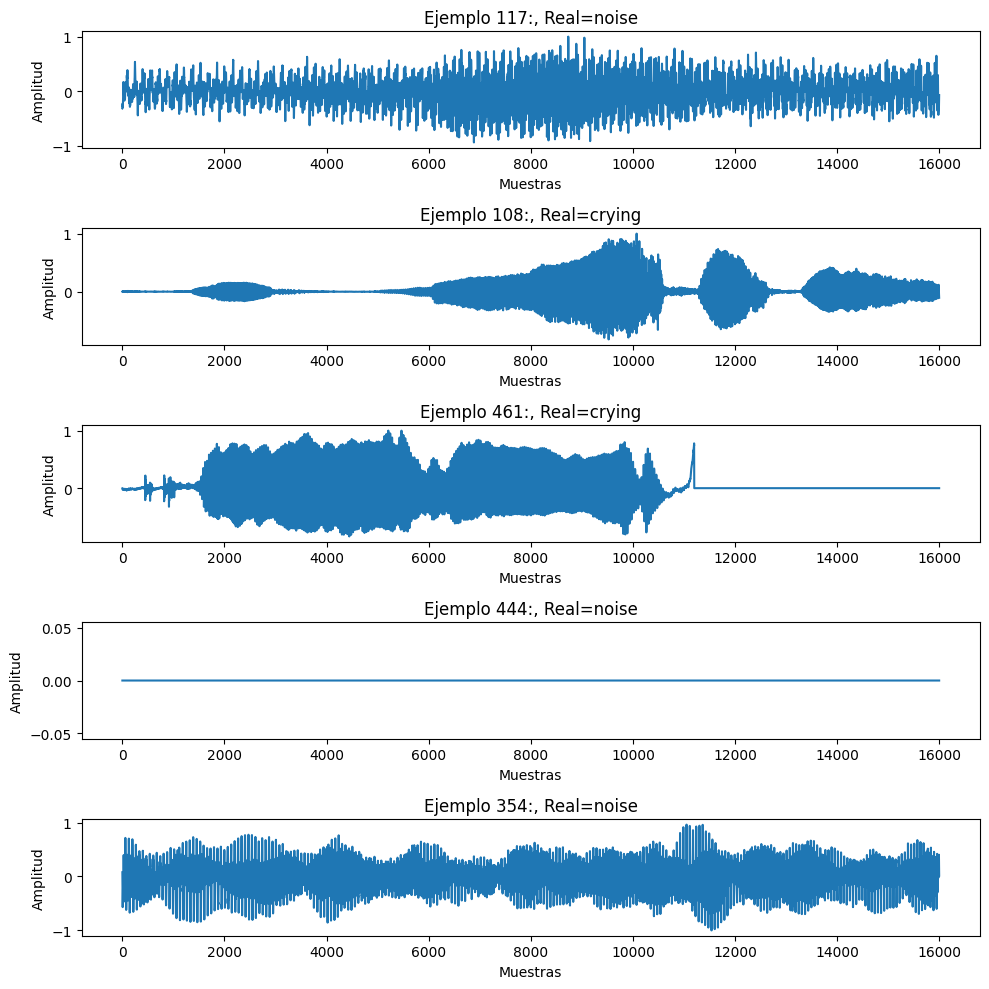

In [4]:
import matplotlib.pyplot as plt
# Rutas de los datos
TRAIN_PATH = "../data_train/processed_audio/train.npz"
TEST_PATH = "../data_train/processed_audio/test.npz"

# Cargar datos procesados
data_train = np.load(TRAIN_PATH)
data_test = np.load(TEST_PATH)

# Extraer datos y etiquetas
X_train, y_train = data_train["X"], data_train["y"]
X_test, y_test = data_test["X"], data_test["y"]

# Imprimir información sobre los datos
print("Datos cargados correctamente:")
print(f"Train: X={X_train.shape}, y={y_train.shape}")  # (n_samples, SAMPLES_PER_AUDIO)
print(f"Test:  X={X_test.shape}, y={y_test.shape}")    # (n_samples, SAMPLES_PER_AUDIO)

# Diccionario de etiquetas
labels = ["crying", "noise"]

# Seleccionar múltiples muestras aleatorias
num_samples = 5  # Cambia este valor para probar más audios
sample_indices = random.sample(range(len(X_test)), num_samples)


labels = ["crying", "noise"]


fig, axes = plt.subplots(num_samples, 1, figsize=(10, 2 * num_samples))

for i, idx in enumerate(sample_indices):
    input_data = X_test[idx]
    real_class = np.argmax(y_test[idx])

    axes[i].plot(X_test[idx])
    axes[i].set_title(f"Ejemplo {idx}:, Real={labels[real_class]}")
    axes[i].set_xlabel("Muestras")
    axes[i].set_ylabel("Amplitud")

plt.tight_layout()
plt.show()

## Versiones MFCC

In [ ]:
import os
import random
import numpy as np
import scipy.signal
import scipy.fftpack
import soundfile as sf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Parámetros globales
SAMPLE_RATE = 16000
DURATION = 1
SAMPLES_PER_AUDIO = SAMPLE_RATE * DURATION

N_MFCC = 13
N_FFT = 640
HOP_LENGTH = 320
MAX_LEN = 49
NUM_MEL_FILTERS = 26
EPSILON = 1e-8

# Directorios
RAW_DATA_DIR        = "../data_train/raw"
PROCESSED_DATA_DIR  = "../data_train/processed_MFCC"
os.makedirs(PROCESSED_DATA_DIR, exist_ok=True)

def hz_to_mel(hz):
    return 2595.0 * np.log10(1.0 + hz / 700.0)

def mel_to_hz(mel):
    return 700.0 * (10**(mel / 2595.0) - 1.0)

def load_audio(file_path, target_sr=SAMPLE_RATE, epsilon=EPSILON):
    try:
        audio, sr = sf.read(file_path)
    except Exception as e:
        print(f"Error al cargar {file_path}: {e}")
        return None

    if audio.size == 0:
        return None

    # Mono
    if audio.ndim > 1:
        audio = np.mean(audio, axis=1)
    # Resample
    if sr != target_sr:
        num_samples = int(len(audio) * target_sr / sr)
        if num_samples <= 0:
            return None
        audio = scipy.signal.resample(audio, num_samples)
    # Truncar/pad
    if len(audio) > SAMPLES_PER_AUDIO:
        audio = audio[:SAMPLES_PER_AUDIO]
    else:
        audio = np.pad(audio, (0, SAMPLES_PER_AUDIO - len(audio)), mode='constant')
    # Normalizar
    audio -= np.mean(audio)
    max_val = np.max(np.abs(audio))
    if max_val > 0:
        audio /= (max_val + epsilon)

    # MFCC
    frame_len = N_FFT
    frame_step = HOP_LENGTH
    num_frames = (len(audio) - frame_len) // frame_step + 1
    frames_to_process = min(num_frames, MAX_LEN)
    window = np.hamming(frame_len)

    # Mel filter bank
    num_mel_points = NUM_MEL_FILTERS + 2
    mel_low = hz_to_mel(0.0)
    mel_high = hz_to_mel(target_sr/2)
    mel_points = np.linspace(mel_low, mel_high, num_mel_points)
    hz_points = mel_to_hz(mel_points)
    bin_indices = np.floor((frame_len+1)*hz_points/target_sr).astype(int)

    mfcc_feats = []
    for m in range(frames_to_process):
        start = m*frame_step
        frame = audio[start:start+frame_len] * window
        spectrum = np.fft.rfft(frame)
        power_spec = (np.abs(spectrum)**2)/frame_len

        # Mel energies
        mel_energies = np.zeros(NUM_MEL_FILTERS)
        for i in range(1, num_mel_points-1):
            start_b, center_b, end_b = bin_indices[i-1], bin_indices[i], bin_indices[i+1]
            # ascend
            mel_energies[i-1] += np.sum(
                power_spec[start_b:center_b] *
                (np.arange(start_b,center_b)-start_b)/(center_b-start_b+epsilon)
            )
            # descend
            mel_energies[i-1] += np.sum(
                power_spec[center_b:end_b] *
                (end_b-np.arange(center_b,end_b))/(end_b-center_b+epsilon)
            )
        log_mel = np.log(mel_energies + epsilon)
        dct_res = scipy.fftpack.dct(log_mel, type=2, norm='ortho')
        mfcc_feats.append(dct_res[:N_MFCC])

    # Padding si faltan frames
    if frames_to_process < MAX_LEN:
        for _ in range(MAX_LEN-frames_to_process):
            mfcc_feats.append(np.zeros(N_MFCC, dtype=np.float32))

    return np.array(mfcc_feats, dtype=np.float32)

def process_and_save_data(raw_data_dir, processed_data_dir):
    # 1) Listar archivos por clase
    crying_dir = os.path.join(raw_data_dir, "crying")
    noise_dir  = os.path.join(raw_data_dir, "noise")

    crying_files = [os.path.join(crying_dir, f)
                    for f in os.listdir(crying_dir)
                    if f.lower().endswith(('.wav','.ogg'))] \
                   if os.path.isdir(crying_dir) else []
    noise_files  = [os.path.join(noise_dir, f)
                    for f in os.listdir(noise_dir)
                    if f.lower().endswith(('.wav','.ogg'))] \
                   if os.path.isdir(noise_dir) else []

    if not crying_files or not noise_files:
        print("Una de las carpetas 'crying' o 'noise' está vacía o no existe.")
        return

    # 2) Determinar mínimo
    n_per_class = min(len(crying_files), len(noise_files))
    random.seed(42)
    crying_files = random.sample(crying_files, n_per_class)
    noise_files  = random.sample(noise_files,  n_per_class)

    # 3) Procesar y etiquetar
    X, y = [], []
    for path in crying_files:
        feats = load_audio(path)
        if feats is not None:
            X.append(feats); y.append(0)
    for path in noise_files:
        feats = load_audio(path)
        if feats is not None:
            X.append(feats); y.append(1)
    if not X:
        print("No se procesó ningún audio válido.")
        return

    X = np.stack(X)            # (2*n_per_class, MAX_LEN, N_MFCC)
    y = np.array(y, dtype=int)

    # 4) Dividir train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2,
        random_state=42,
        shuffle=True,
        stratify=y
    )

    # 5) One-hot
    y_train = to_categorical(y_train, num_classes=2)
    y_test  = to_categorical(y_test,  num_classes=2)

    # 6) Guardar
    train_path = os.path.join(processed_data_dir, "train.npz")
    test_path  = os.path.join(processed_data_dir, "test.npz")
    np.savez_compressed(train_path, X=X_train, y=y_train)
    np.savez_compressed(test_path,  X=X_test,  y=y_test)

    print(f"Procesados {n_per_class} muestras por clase.")
    print(f"Train: {train_path} -> X{X_train.shape}, y{y_train.shape}")
    print(f"Test : {test_path}  -> X{X_test.shape},  y{y_test.shape}")

# Ejecutar
process_and_save_data(RAW_DATA_DIR, PROCESSED_DATA_DIR)


Procesados 1259 muestras por clase.
Train: ../data_train/processed_MFCC\train.npz -> X(2012, 49, 13), y(2012, 2)
Test : ../data_train/processed_MFCC\test.npz  -> X(504, 49, 13),  y(504, 2)


Script para visualizar los datos

Datos cargados correctamente:
Train: X=(2012, 49, 13), y=(2012, 2)
Test:  X=(504, 49, 13), y=(504, 2)
Ejemplo seleccionado (índice 479):
[[-3.35655174e+01 -2.10300875e+00 -1.04351578e+01  6.96712351e+00
   4.52893257e+00 -8.85683060e-01  9.61862206e-01  1.02927041e+00
   8.40346217e-01  1.18978806e-01  3.43816876e+00  2.31704593e+00
  -2.66132927e+00]
 [-3.23179703e+01 -9.24029768e-01 -1.12966156e+01  8.06198692e+00
   4.16596603e+00 -9.49554861e-01  7.54542649e-01 -4.40767050e-01
   1.95020780e-01  3.85656238e-01  4.15949583e+00  2.41962218e+00
  -2.03719187e+00]
 [-3.14827194e+01 -1.97747481e+00 -1.21479511e+01  7.22097540e+00
   4.11117792e+00 -9.59206402e-01  1.51807010e+00  1.32912546e-01
  -6.07083775e-02  9.58041787e-01  4.01248598e+00  1.36093271e+00
  -2.08670950e+00]
 [-2.92860222e+01 -2.37050557e+00 -1.13499393e+01  6.31410408e+00
   3.46717000e+00 -1.57593596e+00  1.68462372e+00  6.81354478e-02
  -3.98160785e-01  1.64310825e+00  4.19482040e+00  1.44386065e+00
  -1.69482160e

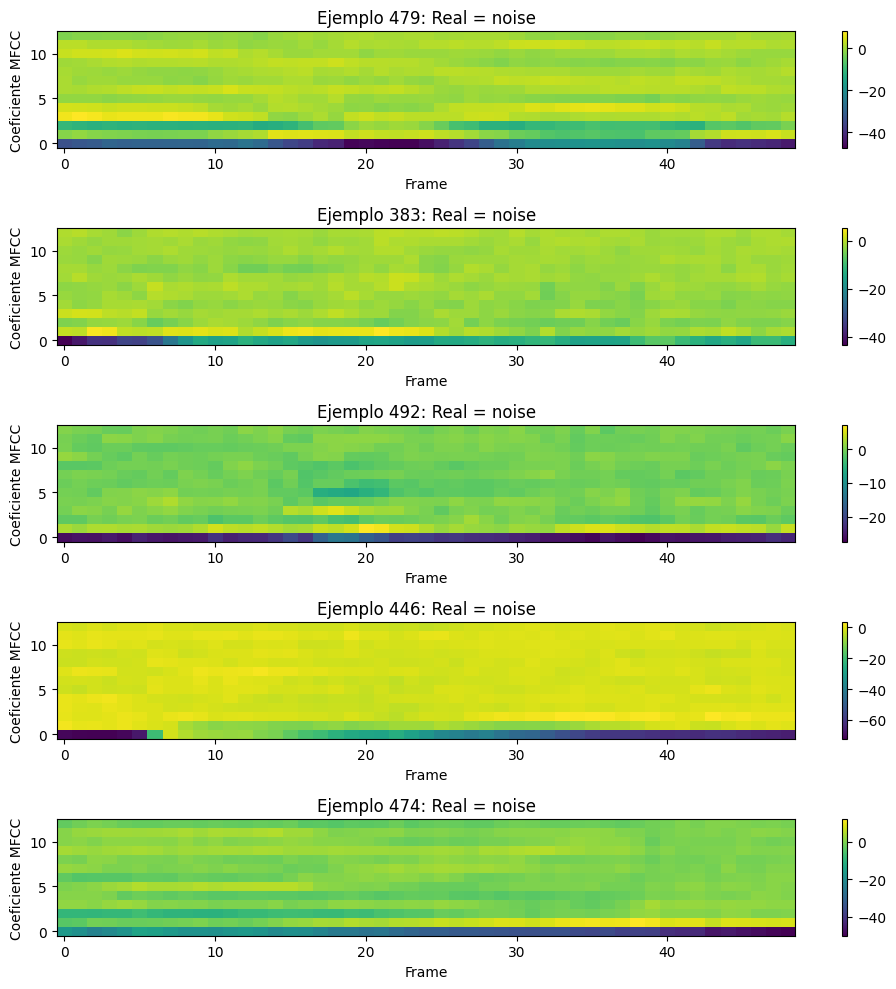

In [6]:
import random
import matplotlib.pyplot as plt
# Rutas de los datos
TRAIN_PATH = "../data_train/processed_MFCC/train.npz"
TEST_PATH = "../data_train/processed_MFCC/test.npz"

# Cargar datos procesados
data_train = np.load(TRAIN_PATH)
data_test = np.load(TEST_PATH)

# Extraer datos y etiquetas
X_train, y_train = data_train["X"], data_train["y"]
X_test, y_test = data_test["X"], data_test["y"]

# Imprimir información sobre los datos
print("Datos cargados correctamente:")
print(f"Train: X={X_train.shape}, y={y_train.shape}")  # Ej.: (n_samples, MAX_LEN, N_MFCC)
print(f"Test:  X={X_test.shape}, y={y_test.shape}")

# Diccionario de etiquetas
labels = ["crying", "noise"]

# Seleccionar múltiples muestras aleatorias
num_samples = 5  # Cambia este valor para ver más ejemplos
sample_indices = random.sample(range(len(X_test)), num_samples)

# Crear gráfica para visualizar MFCC
fig, axes = plt.subplots(num_samples, 1, figsize=(10, 2 * num_samples))

for i, idx in enumerate(sample_indices):
    mfcc_data = X_test[idx]  # Forma: (frames, n_mfcc)
    real_class = np.argmax(y_test[idx])

    # Usar imshow para visualizar la matriz de MFCC (se transpone para que los coeficientes se muestren en el eje vertical)
    im = axes[i].imshow(mfcc_data.T, aspect='auto', origin='lower', interpolation='nearest')
    axes[i].set_title(f"Ejemplo {idx}: Real = {labels[real_class]}")
    axes[i].set_xlabel("Frame")
    axes[i].set_ylabel("Coeficiente MFCC")
    fig.colorbar(im, ax=axes[i])

    print("Ejemplo seleccionado (índice {}):".format(sample_indices[0]))
    print(X_test[sample_indices[0]])

plt.tight_layout()
plt.show()

